In [166]:
import numpy as np 
import matplotlib.pyplot as plt 
import numpy.linalg as la 
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from scipy.stats import multivariate_normal
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from tqdm import tqdm
import time

## Utility Functions 

In [167]:
def computeError(Z, w, meany, y): 
    '''COMPUTEERROR computes classification errors for ridge regression models
    that are trained using zero-mean label vectors
    Inputs:
        Z the random feature matrix
        w the optimized classication parameter vector
        meany the mean of ytrain used to train w
        y the true labels for datapoints in Z'''
    
    pred = np.sign(Z.T@ w + meany)
    error = np.average(pred != y)
    fn = np.average((pred != y) & (y == 1))/error
    fp = np.average((pred != y) & (y == -1))/error
    return error, fp, fn 


def createOptimizedGaussianKernelParams(D, W_opt, b_opt, alpha_distrib): 
    '''CREATEOPTIMIZEDGAUSSIANKERNELPARAMS generates parameters for an optimized
    Gaussian kernel. If we ask to create more random features than the number
    of features in the optmized kernel, we will just return the number of
    features in the optimized kernel. If we ask for fewer, then we sample
    from the distribution for the optimized kernel.
    
    Inputs:
        D is the number of random features we wish to generate
        W_opt, b_opt, alpha_distrib are outputs from OptimizeGaussianKernel
    
    Outputs:
        D_new the number of random features we actually have now
        W_new, b_new the parameters for those random features'''
    
    W_new = W_opt 
    b_new = b_opt 
    D_new = b_opt.shape[1] 
    if D < D_new: 
        p = np.random.uniform(size = (D,1))
        summand = np.tile(p, (1, len(alpha_distrib))) - np.tile(alpha_distrib.T, (D, 1))
        inds = np.sum(summand, axis = 1)+1
        W_new = W_opt[:, inds]
        b_new = b_opt[inds]
        D_new = D 
    return D_new, W_new, b_new

def createOptimizedLinearKernelParams(D, idx_opt, alpha_distrib): 
    '''CREATEOPTIMIZEDGAUSSIANKERNELPARAMS generates parameters for an optimized
    Gaussian kernel. If we ask to create more random features than the number
    of features in the optmized kernel, we will just return the number of
    features in the optimized kernel. If we ask for fewer, then we sample
    from the distribution for the optimized kernel.
    
    Inputs:
        D is the number of random features we wish to generate
        W_opt, b_opt, alpha_distrib are outputs from OptimizeGaussianKernel
    
    Outputs:
        D_new the number of random features we actually have now
        W_new, b_new the parameters for those random features'''
    
    idx_new = idx_opt
    D_new = size(idx_opt, 2)
    if D < D_new: 
        p = np.random.uniform(size = (D,1))
        summand = np.tile(p, (1, len(alpha_distrib))) - np.tile(alpha_distrib.T, (D, 1))
        inds = np.sum(summand, axis = 1)+1
        idx_new = idx_opt[:, inds]
        D_new = D 
    return D_new, idx_new

def linear_chi_square(v, u, rho, acc = 1e-8):
    '''LINEAR_CHI_SQUARE Solves the particular quadratically constrained
    linear problem.

    x = linear_chi_square(v, u, rho, acc) sets x to be the solution to the
      optimization problem

    min. x.T @ v = x.T @ Phi@y \odot Phi@y
    s.t. norm(x - u, 2)^2 <= rho
         sum(x) == 1, x >= 0.

    Uses a binary search strategy along with projections onto the simplex to
    solve the problem in O(n log (n / acc)) time to solve to accuracy acc (in
    duality gap)


    A partial dual to the problem is given by the Lagrangian

    L(x, lambda) = (lambda/2) * (norm(x - u, 2)^2 - rho) + x' * v
    subject to     sum(x) == 1, x >= 0.

    Then we maximize lambda over inf_x L(x, lambda), the infimum taken over
    the constrained set.'''
    
    
    duality_gap = np.inf
    
    max_lambda = np.inf
    min_lambda = 0
    
    x = project_onto_simplex(u, 1) 
    
    if (la.norm(x - u)**2 > rho): 
        raise ValueError('Problem is not feasible')

    start_lambda = 1
    while (np.isinf(max_lambda)):
        x = project_onto_simplex(u - v/start_lambda, 1)
        lam_grad = 0.5 * la.norm(x - u, 2)**2 - rho/2
        if (lam_grad < 0): 
            max_lambda = start_lambda 
        else: 
            start_lambda = start_lambda * 2 
            
    while (max_lambda - min_lambda > acc * start_lambda): 
        lamda = (min_lambda + max_lambda) / 2 
        x = project_onto_simplex(u - v/lamda, 1)
        lam_grad = 0.5 * la.norm(x - u, 2)**2  - rho/2
        if (lam_grad < 0): 
            #Then lambda is too large, so decrease max_lambda 
            max_lambda = lamda
        else: 
            min_lambda = lamda     
    return x

def createRandomFourierFeatures(D, W, b, X): 
    '''CREATERANDOMFOURIERFEATURES creates Gaussian random features
    Inputs:
        D the number of features to make
        W, b the parameters for those features (d x D and 1 x D)
        X the datapoints to use to generate those features (d x N)'''
    Z = np.sqrt(2/D)*np.cos(W.T @ X + b.T)
    return Z


def project_onto_simplex(v, B): 
    m = len(v) 
    bget = False 
    s = np.sort(v)[::-1]
    tmpsum = 0 
    for ii in range(0, m-1): 
        tmpsum += s[ii]
        tmax = (tmpsum - 1)/(ii+1)
        if tmax >=s[ii+1]:
            bget = True
            break 
    if not(bget): 
        tmax = (tmpsum + s[m-1] - 1)/m
    x = np.maximum(v - tmax, 0)
    if sum(x) != B:
        if np.abs(sum(x) - B) >= 1: 
            print(sum(x))
            print(v)
            raise ValueError('Sum way too far from B')
    return x 
    

## Optimizing Kernels 

In [168]:
def optimizeGaussianKernel(Xtrain, ytrain, Nw, rho, tol): 
    '''OPTIMIZEGAUSSIANKERNEL optimizes random features generated for the
    Gaussian kernel using the chi-square divergence measure.
    See http://amansinha.org/docs/SinhaDu16.pdf for more info on the theory.
    Inputs:
        Xtrain is the d x N training data matrix, where N is the number of datapoints and d is the dimension.
        ytrain is the N x 1 training label vector. The binary classes should be 1 and -1.
        Nw is the number of random features to use.
        rho governs the maximum allowable divergence form the original kernel distribution
        tol is the tolerance for the solver.

    Outputs: 
        W_opt is the optimized matrix of random features
        b_opt is the optimized vector of offsets
        alpha is the probability distribution for the random features with close-to-zero-probability features removed
        alpha_distrib is cumulative distribution function over all random features'''
    
    d, _ = Xtrain.shape
    
    W = np.random.normal(0, 1, size = (d, Nw))
    b = np.random.uniform(size = (1,Nw))*2*np.pi

    Phi = np.cos(Xtrain.T @ W + b)
    Ks = Phi.T @ ytrain
    Ks = Ks**2
    alpha_temp = linear_chi_square(-Ks, 1/Nw*np.ones((Nw,)), rho/Nw, tol) 
    
    
    idx = (alpha_temp > eps).reshape(-1)
    alpha = alpha_temp[idx] 
    W_opt = W[:, idx]
    b_opt = b[:, idx]
    alpha_distrib = np.cumsum(alpha/sum(alpha))
    return W_opt, b_opt, alpha, alpha_distrib

def optimizeLinearKernel(Xtrain, ytrain, rho, tol): 
    '''OPTIMIZELINEARKERNEL optimizes random features generated for the
    linear kernel using the chi-square divergence measure.
    See http://amansinha.org/docs/SinhaDu16.pdf for more info on the theory.
    Inputs:
        Xtrain is the d x N training data matrix, where N is the number of datapoints and d is the dimension.
        ytrain is the N x 1 training label vector. The binary classes should be 1 and -1.
        rho governs the maximum allowable divergence form the original kernel distribution
        tol is the tolerance for the solver.

    Outputs: 
        idx_opt is the optimized matrix of random features
        alpha is the probability distribution for the random features with close-to-zero-probability features removed 
        alpha_distrib is cumulative distribution function over all random features'''
    
    d, _ = Xtrain.shape 
    wd = np.arange(1, d+1)
    Nw = d
    
    Ks = Xtrain @ ytrain 
    Ks = Ks**2 
    
    alpha_temp = linear_chi_square(-Ks, 1/Nw*np.ones((Nw,)), rho/Nw, tol)
    idx = alpha_temp > eps
    alpha = alpha_temp[idx]
    idx_opt = wd[idx]
    
    alpha_distrib = np.cumsum(alpha/sum(alpha))
    return idx_opt, alpha, alpha_distrib
    

## Examples 
Learning kernels with Random Features, example script

- Generate some data
- Create normally distributed points 
- Let the true classifier between classes be a specified radius

In [169]:
eps = np.finfo(float).eps
n = int(1e4)
d = 2
Xtrain = np.random.normal(size = (d, n))
Xtest = np.random.normal(size = (d, int(n/10)))

ytrain = np.sqrt(np.sum(Xtrain*Xtrain, axis = 0)) > np.sqrt(d)
ytrain = ytrain*2 - 1
ytest = np.sqrt(np.sum(Xtest*Xtest, axis = 0)) > np.sqrt(d)
ytest = ytest*2 -1 

## Optimize Kernel 
# this example uses the Gaussian Kernel and chi-square divergence 
Nw = int(2e4)
rho = Nw*0.01
tol = 1e-11

Wopt, bopt, alpha, alpha_distrib = optimizeGaussianKernel(Xtrain, ytrain, Nw, rho, tol)

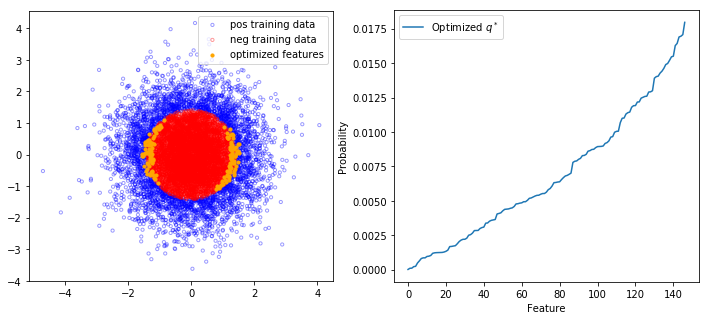

In [170]:
fig, axs = plt.subplots(1, 2, figsize =(12, 5))
ax, ax1 = axs
# ax.plot(np.sort(alpha))
# print(Xtrain.T)
Xneg = Xtrain[:, ytrain < 0]
Xpos = Xtrain[:, ytrain > 0]
# print(Xneg.shape)
# print(Xpos.shape)

ax.scatter(Xpos[0], Xpos[1], facecolor = 'none', edgecolor = 'b', s= 10, alpha = 0.4,  label = 'pos training data')
ax.scatter(Xneg[0], Xneg[1], facecolor = 'none', s= 10, edgecolor = 'r', alpha = 0.4,  label = 'neg training data')
ax.scatter(Wopt[0], Wopt[1], color = 'orange', s = 10, label = 'optimized features')
# ax.scatter(Xtest[0], Xtest[1], s = 2, color = 'r')
ax.set_aspect('equal')
ax.legend()
ax1.plot(np.sort(alpha), label = 'Optimized $q^*$')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Probability')
ax1.legend()
plt.show()

## Linear Regression 

In [ ]:
eps = np.finfo(float).eps

n = int(1e4)
Nw = int(2e4)
rho = Nw*0.01
tol = 1e-11

ds = np.linspace(2, 15, 14)
err_regs_train = []
err_opts_train = []
err_regs_test = []
err_opts_test = []

for d in ds: 
    d = int(d)
    Xtrain = np.random.normal(size = (d, n))
    Xtest = np.random.normal(size = (d, int(n/10)))

    ytrain = np.sqrt(np.sum(Xtrain*Xtrain, axis = 0)) > np.sqrt(d)
    ytrain = ytrain*2 - 1
    ytest = np.sqrt(np.sum(Xtest*Xtest, axis = 0)) > np.sqrt(d)
    ytest = ytest*2 -1 

    ## Optimize Kernel 
    # this example uses the Gaussian Kernel and chi-square divergence 
    Wopt, bopt, alpha, alpha_distrib = optimizeGaussianKernel(Xtrain, ytrain, Nw, rho, tol)


    ## Create random features using optimized kernel 
    # pick a number of random features to use for the model 
    D = len(alpha)
    # generate parameters for the optimized kernel 
    D_opt, W_opt, b_opt = createOptimizedGaussianKernelParams(D, Wopt, bopt, Xtrain)
    # create optimized features using the training data and test data
    Z_opt_train = createRandomFourierFeatures(D_opt, W_opt, b_opt, Xtrain)
    Z_opt_test = createRandomFourierFeatures(D_opt, W_opt, b_opt, Xtest)


    # generate regular Gaussian features for comparison
    W = np.random.normal(size = (d, D))
    b = np.random.uniform(size = (1, D))*2*np.pi
    Z_train = createRandomFourierFeatures(D, W, b, Xtrain)
    Z_test = createRandomFourierFeatures(D, W, b, Xtest)

    ## Train models 
    # For simplicity, train linear regression models (even though this is a classification problem! )
    meany = np.average(ytrain)
    lamda = 0.05
    w_opt = la.solve((Z_opt_train @ Z_opt_train.T + lamda * np.eye(D_opt)), (Z_opt_train @ (ytrain - meany)))
    w = la.solve((Z_train @ Z_train.T + lamda * np.eye(D)), (Z_train @ (ytrain-meany)))
    
    err_reg_train,fp, fn = computeError(Z_train, w, meany, ytrain)
    err_opt_train,fp, fn = computeError(Z_opt_train, w_opt, meany, ytrain)
    err_regs_train.append(err_reg_train)
    err_opts_train.append(err_opt_train)
    
    err_reg_test,fp, fn = computeError(Z_test, w, meany, ytest)
    err_opt_test,fp, fn = computeError(Z_opt_test, w_opt, meany, ytest)
    err_regs_test.append(err_reg_test)
    err_opts_test.append(err_opt_test)
    

In [ ]:
fig, ax = plt.subplots(1,)

ax.plot(ds, err_regs_train, label = 'GK-train')
ax.plot(ds, err_regs_test, 'b--', label = 'GK-test')
ax.plot(ds, err_opts_train, 'orange', label = 'OK-train')
ax.plot(ds, err_opts_test, 'r--', label = 'OK-test')
ax.set_xlabel('dimensionality')
ax.set_ylabel('training and testing error')
ax.legend()
plt.show()

## Logistic Regression 

In [ ]:
def computelogError(Z, clf, y): 
    '''COMPUTEERROR computes classification errors for ridge regression models
    that are trained using zero-mean label vectors
    Inputs:
        Z the random feature matrix
        w the optimized classication parameter vector
        meany the mean of ytrain used to train w
        y the true labels for datapoints in Z'''
    
    pred = clf.predict(Z)
    error = np.average(pred != y)
    fn = np.average((pred != y) & (y == 1))/error
    fp = np.average((pred != y) & (y == -1))/error
    return error, fp, fn 

eps = np.finfo(float).eps

n = int(1e4)
Nw = int(2e4)
rho = Nw*0.01
tol = 1e-11

ds = np.linspace(2, 15, 14)
err_regs_train = []
err_opts_train = []
err_regs_test = []
err_opts_test = []

for d in ds: 
    d = int(d)
    Xtrain = np.random.normal(size = (d, n))
    Xtest = np.random.normal(size = (d, int(n/10)))

    ytrain = np.sqrt(np.sum(Xtrain*Xtrain, axis = 0)) > np.sqrt(d)
    ytrain = ytrain*2 - 1
    ytest = np.sqrt(np.sum(Xtest*Xtest, axis = 0)) > np.sqrt(d)
    ytest = ytest*2 -1 

    ## Optimize Kernel 
    # this example uses the Gaussian Kernel and chi-square divergence 
    Wopt, bopt, alpha, alpha_distrib = optimizeGaussianKernel(Xtrain, ytrain, Nw, rho, tol)


    ## Create random features using optimized kernel 
    # pick a number of random features to use for the model 
    D = len(alpha)
    # generate parameters for the optimized kernel 
    D_opt, W_opt, b_opt = createOptimizedGaussianKernelParams(D, Wopt, bopt, Xtrain)
    # create optimized features using the training data and test data
    Z_opt_train = createRandomFourierFeatures(D_opt, W_opt, b_opt, Xtrain)
    Z_opt_test = createRandomFourierFeatures(D_opt, W_opt, b_opt, Xtest)


    # generate regular Gaussian features for comparison
    W = np.random.normal(size = (d, D))
    b = np.random.uniform(size = (1, D))*2*np.pi
    Z_train = createRandomFourierFeatures(D, W, b, Xtrain)
    Z_test = createRandomFourierFeatures(D, W, b, Xtest)

    ## Train models 
    # For simplicity, train linear regression models (even though this is a classification problem! )
    meany = np.average(ytrain)
    clf_opt = LogisticRegression(random_state=0, solver='lbfgs').fit(Z_opt_train.T, ytrain)
    clf_rand = LogisticRegression(random_state=0, solver='lbfgs').fit(Z_train.T, ytrain)
    
    err_reg_train,fp, fn = computelogError(Z_train.T, clf_rand, ytrain)
    err_opt_train,fp, fn = computelogError(Z_opt_train.T, clf_opt, ytrain)
    err_regs_train.append(err_reg_train)
    err_opts_train.append(err_opt_train)
    
    err_reg_test,fp, fn = computelogError(Z_test.T, clf_rand, ytest)
    err_opt_test,fp, fn = computelogError(Z_opt_test.T, clf_opt, ytest)
    err_regs_test.append(err_reg_test)
    err_opts_test.append(err_opt_test)

In [ ]:
fig, ax = plt.subplots(1,)

ax.plot(ds, err_regs_train, label = 'GK-train')
ax.plot(ds, err_regs_test, 'b--', label = 'GK-test')
ax.plot(ds, err_opts_train, 'orange', label = 'OK-train')
ax.plot(ds, err_opts_test, 'r--', label = 'OK-test')
ax.set_xlabel('dimensionality')
ax.set_ylabel('error')
ax.legend()
plt.show()


## Looking at the Decision Boundaries for optimized features

In [164]:
eps = np.finfo(float).eps

X,y = make_moons(n_samples = 300, noise=0.1, random_state=0)

y[y==0] = -1
    
X_train, X_test, ytrain, ytest = train_test_split(X, y, test_size=.2)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std

Xtrain = X_train.T
Xtest = X_test.T

## Optimize Kernel 
# this example uses the Gaussian Kernel and chi-square divergence 
Nw = int(2e4)
rho = Nw*0.001
tol = 1e-11

Wopt, bopt, alpha, alpha_distrib = optimizeGaussianKernel(Xtrain, ytrain, Nw, rho, tol)

#Solving the standard regression problem with the optimized kernel
Xneg = Xtrain[:,ytrain > 0]
Xpos = Xtrain[:,ytrain < 0]

d = 2
xx, yy = np.meshgrid(np.linspace(-2.5, 2.5),
                         np.linspace(-2.5, 2.5))
mesh = np.stack([xx.ravel(),yy.ravel()],axis=1)

## Create random features using optimized kernel 
# pick a number of random features to use for the model 
D = len(alpha)
# generate parameters for the optimized kernel 
D_opt, W_opt, b_opt = createOptimizedGaussianKernelParams(D, Wopt, bopt, Xtrain)
# create optimized features using the training data and test data
Z_opt_train = createRandomFourierFeatures(D_opt, W_opt, b_opt, Xtrain)
Z_opt_test = createRandomFourierFeatures(D_opt, W_opt, b_opt, Xtest)

# generate regular Gaussian features for comparison
W = np.random.normal(size = (d, D))
b = np.random.uniform(size = (1, D))*2*np.pi
Z_train = createRandomFourierFeatures(D, W, b, Xtrain)
Z_test = createRandomFourierFeatures(D, W, b, Xtest)

## Train models 
# For simplicity, train linear regression models (even though this is a classification problem! )
meany = np.average(ytrain)
lamda = 0.05
w_opt = la.solve((Z_opt_train @ Z_opt_train.T + lamda * np.eye(D_opt)), (Z_opt_train @ (ytrain - meany)))
w = la.solve((Z_train @ Z_train.T + lamda * np.eye(D)), (Z_train @ (ytrain-meany)))

Z_opt_mesh = createRandomFourierFeatures(D_opt, W_opt, b_opt, mesh.T)
Z_mesh = createRandomFourierFeatures(D, W, b,mesh.T)

pred = (Z_opt_mesh.T@ w_opt + meany).reshape(xx.shape)
rand_pred = (Z_mesh.T@ w + meany).reshape(xx.shape)

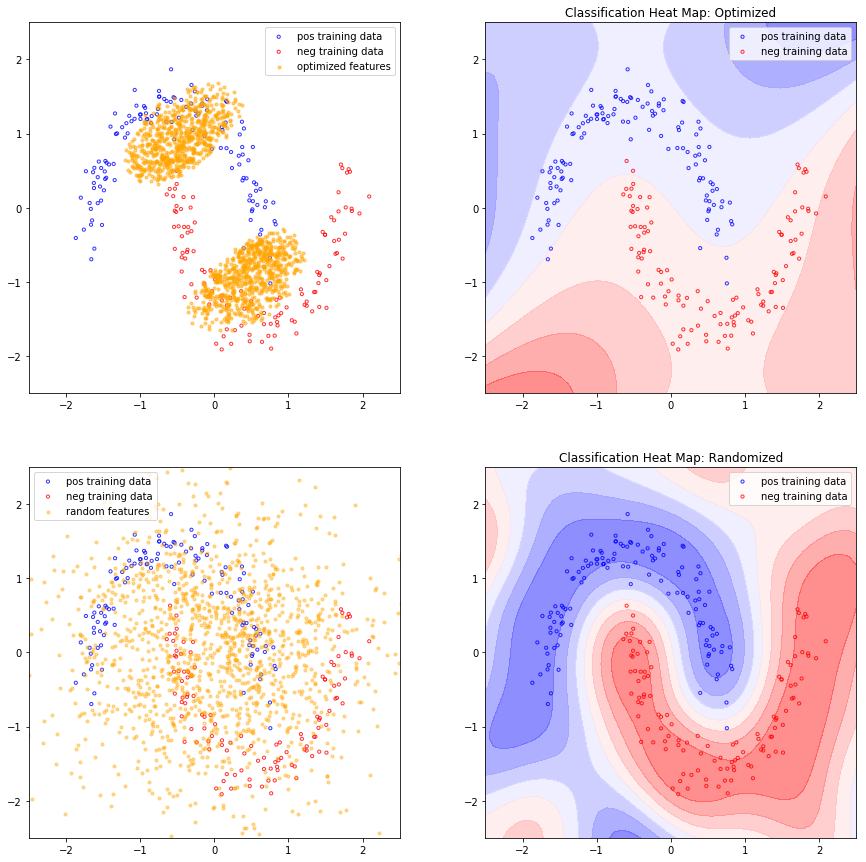

In [165]:
fig, ax = plt.subplots(2, 2, figsize =(15, 15))
ax[0,0].scatter(Xpos[0], Xpos[1], facecolor = 'none', edgecolor = 'b', s= 10, alpha = 0.8,  label = 'pos training data')
ax[0,0].scatter(Xneg[0], Xneg[1], facecolor = 'none', s= 10, edgecolor = 'r', alpha = 0.8,  label = 'neg training data')
ax[0,0].scatter(Wopt[0], Wopt[1], color = 'orange',alpha = 0.5, s = 10, label = 'optimized features')
ax[0,0].set_aspect('equal')
ax[0,0].set_ylim([-2.5,2.5])
ax[0,0].set_xlim([-2.5,2.5])
ax[0,0].legend()

ax[0,1].contourf(xx, yy, pred, cmap = plt.cm.bwr, alpha=.5)
ax[0,1].scatter(Xpos[0], Xpos[1], facecolor = 'none', edgecolor = 'b', s= 10, alpha = 0.8,  label = 'pos training data')
ax[0,1].scatter(Xneg[0], Xneg[1], facecolor = 'none', s= 10, edgecolor = 'r', alpha = 0.8,  label = 'neg training data')
ax[0,1].set_aspect('equal')
ax[0,1].set_ylim([-2.5,2.5])
ax[0,1].set_xlim([-2.5,2.5])
ax[0,1].set_title('Classification Heat Map: Optimized')
ax[0,1].legend()

ax[1,0].scatter(Xpos[0], Xpos[1], facecolor = 'none', edgecolor = 'b', s= 10, alpha = 0.8,  label = 'pos training data')
ax[1,0].scatter(Xneg[0], Xneg[1], facecolor = 'none', s= 10, edgecolor = 'r', alpha = 0.8,  label = 'neg training data')
ax[1,0].scatter(W[0], W[1], color = 'orange', s = 10, alpha = 0.4,  label = 'random features')
ax[1,0].set_aspect('equal')
ax[1,0].set_ylim([-2.5,2.5])
ax[1,0].set_xlim([-2.5,2.5])
ax[1,0].legend()

ax[1,1].contourf(xx, yy, rand_pred, cmap = plt.cm.bwr, alpha=.5)
ax[1,1].scatter(Xpos[0], Xpos[1], facecolor = 'none', edgecolor = 'b', s= 10, alpha = 0.8,  label = 'pos training data')
ax[1,1].scatter(Xneg[0], Xneg[1], facecolor = 'none', s= 10, edgecolor = 'r', alpha = 0.8,  label = 'neg training data')
ax[1,1].set_aspect('equal')
ax[1,1].set_ylim([-2.5,2.5])
ax[1,1].set_xlim([-2.5,2.5])
ax[1,1].set_title('Classification Heat Map: Randomized')
ax[1,1].legend()
plt.show()

In [150]:
eps = np.finfo(float).eps

X,y = make_circles(n_samples = 300, noise=0.1, random_state=1)

y[y==0] = -1
    
X_train, X_test, ytrain, ytest = train_test_split(X, y, test_size=.2)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std

Xtrain = X_train.T
Xtest = X_test.T

## Optimize Kernel 
# this example uses the Gaussian Kernel and chi-square divergence 
Nw = int(2e4)
rho = Nw*0.0005
tol = 1e-11

Wopt, bopt, alpha, alpha_distrib = optimizeGaussianKernel(Xtrain, ytrain, Nw, rho, tol)

#Solving the standard regression problem with the optimized kernel
Xneg = Xtrain[:,ytrain > 0]
Xpos = Xtrain[:,ytrain < 0]

d = 2
xx, yy = np.meshgrid(np.linspace(-2.5, 2.5),
                         np.linspace(-2.5, 2.5))
mesh = np.stack([xx.ravel(),yy.ravel()],axis=1)

## Create random features using optimized kernel 
# pick a number of random features to use for the model 
D = len(alpha)
# generate parameters for the optimized kernel 
D_opt, W_opt, b_opt = createOptimizedGaussianKernelParams(D, Wopt, bopt, Xtrain)
# create optimized features using the training data and test data
Z_opt_train = createRandomFourierFeatures(D_opt, W_opt, b_opt, Xtrain)
Z_opt_test = createRandomFourierFeatures(D_opt, W_opt, b_opt, Xtest)

# generate regular Gaussian features for comparison
W = np.random.normal(size = (d, D))
b = np.random.uniform(size = (1, D))*2*np.pi
Z_train = createRandomFourierFeatures(D, W, b, Xtrain)
Z_test = createRandomFourierFeatures(D, W, b, Xtest)

## Train models 
# For simplicity, train linear regression models (even though this is a classification problem! )
meany = np.average(ytrain)
lamda = 0.05
w_opt = la.solve((Z_opt_train @ Z_opt_train.T + lamda * np.eye(D_opt)), (Z_opt_train @ (ytrain - meany)))
w = la.solve((Z_train @ Z_train.T + lamda * np.eye(D)), (Z_train @ (ytrain-meany)))

Z_opt_mesh = createRandomFourierFeatures(D_opt, W_opt, b_opt, mesh.T)
Z_mesh = createRandomFourierFeatures(D, W, b,mesh.T)

pred = (Z_opt_mesh.T@ w_opt + meany).reshape(xx.shape)
rand_pred = (Z_mesh.T@ w + meany).reshape(xx.shape)

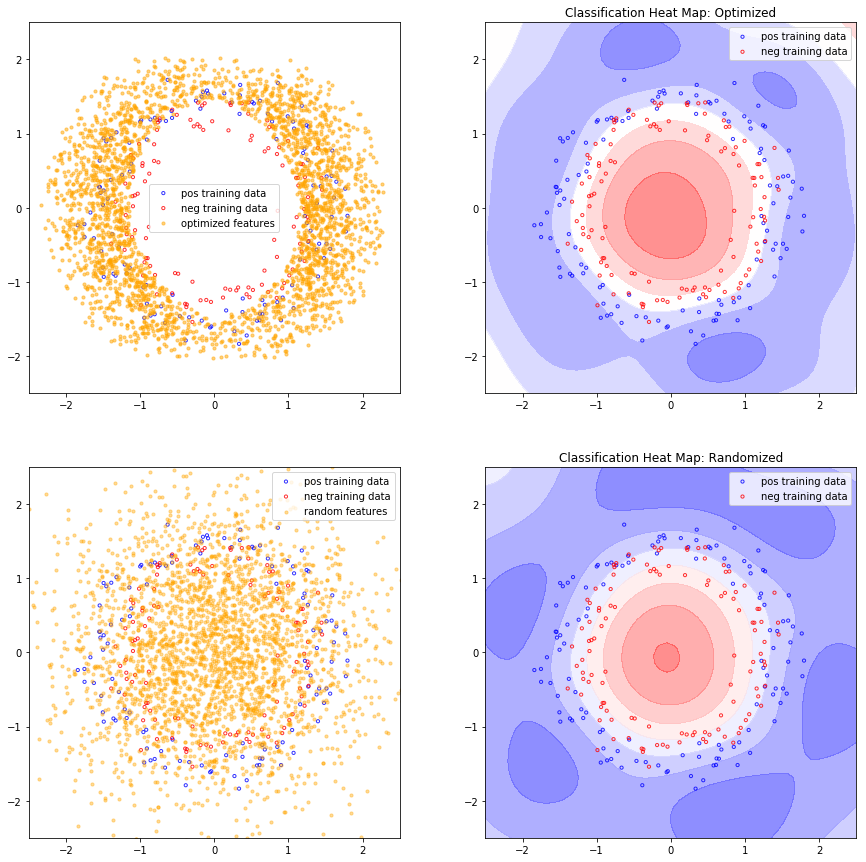

In [151]:
fig, ax = plt.subplots(2, 2, figsize =(15, 15))
ax[0,0].scatter(Xpos[0], Xpos[1], facecolor = 'none', edgecolor = 'b', s= 10, alpha = 0.8,  label = 'pos training data')
ax[0,0].scatter(Xneg[0], Xneg[1], facecolor = 'none', s= 10, edgecolor = 'r', alpha = 0.8,  label = 'neg training data')
ax[0,0].scatter(Wopt[0], Wopt[1], color = 'orange',alpha = 0.5, s = 10, label = 'optimized features')
ax[0,0].set_aspect('equal')
ax[0,0].set_ylim([-2.5,2.5])
ax[0,0].set_xlim([-2.5,2.5])
ax[0,0].legend()

ax[0,1].contourf(xx, yy, pred, cmap = plt.cm.bwr, alpha=.5)
ax[0,1].scatter(Xpos[0], Xpos[1], facecolor = 'none', edgecolor = 'b', s= 10, alpha = 0.8,  label = 'pos training data')
ax[0,1].scatter(Xneg[0], Xneg[1], facecolor = 'none', s= 10, edgecolor = 'r', alpha = 0.8,  label = 'neg training data')
ax[0,1].set_aspect('equal')
ax[0,1].set_ylim([-2.5,2.5])
ax[0,1].set_xlim([-2.5,2.5])
ax[0,1].set_title('Classification Heat Map: Optimized')
ax[0,1].legend()

ax[1,0].scatter(Xpos[0], Xpos[1], facecolor = 'none', edgecolor = 'b', s= 10, alpha = 0.8,  label = 'pos training data')
ax[1,0].scatter(Xneg[0], Xneg[1], facecolor = 'none', s= 10, edgecolor = 'r', alpha = 0.8,  label = 'neg training data')
ax[1,0].scatter(W[0], W[1], color = 'orange', s = 10, alpha = 0.4,  label = 'random features')
ax[1,0].set_aspect('equal')
ax[1,0].set_ylim([-2.5,2.5])
ax[1,0].set_xlim([-2.5,2.5])
ax[1,0].legend()

ax[1,1].contourf(xx, yy, rand_pred, cmap = plt.cm.bwr, alpha=.5)
ax[1,1].scatter(Xpos[0], Xpos[1], facecolor = 'none', edgecolor = 'b', s= 10, alpha = 0.8,  label = 'pos training data')
ax[1,1].scatter(Xneg[0], Xneg[1], facecolor = 'none', s= 10, edgecolor = 'r', alpha = 0.8,  label = 'neg training data')
ax[1,1].set_aspect('equal')
ax[1,1].set_ylim([-2.5,2.5])
ax[1,1].set_xlim([-2.5,2.5])
ax[1,1].set_title('Classification Heat Map: Randomized')
ax[1,1].legend()
plt.show()

## Examples 
Learning kernels with Random Features, example script 2

- Generate some data
- Create normally distributed points 
- Let the true classifier be a certain hypterplane

In [ ]:
eps = np.finfo(float).eps
n = int(1e4)
d = int(1e3)
Xtrain = np.random.normal(size = (d, n))
Xtest = np.random.normal(size = (d, int(n/10)))

true_vec = np.concatenate((np.ones((d//10,)), 0.05*np.random.normal(0, 1, (d-d//10,))))
# true_vec = np.random.normal(0, 1, (d,))

ytrain = Xtrain.T @ true_vec > 0
ytrain = ytrain*2 - 1
ytest = Xtest.T @ true_vec > 0
ytest = ytest*2 -1 

## Optimize Kernel 
# this example uses the linear kernel and chi-square divergence 
rho = d*1e-2
tol = 1e-11

idxopt, alpha, alpha_distrib = optimizeLinearKernel(Xtrain, ytrain, rho, tol)

plt.plot(np.sort(alpha))
plt.xlabel('Feature')
plt.ylabel('Probability')
plt.show()

In [ ]:
fig2, axs2 = plt.subplots(1, 2, figsize =(12, 5))
ax3, ax4 = axs2
# ax.plot(np.sort(alpha))
# print(Xtrain.T)
Xneg = Xtrain[:, ytrain < 0]
Xpos = Xtrain[:, ytrain > 0]
# print(Xneg.shape)
# print(Xpos.shape)

# x1 = np.mgrid[-4:4:100j]
# x2 = -idxopt[0]/idxopt[1]*x1


ax3.scatter(Xpos[0], Xpos[1], facecolor = 'none', edgecolor = 'b', s= 10, alpha = 0.2, label = 'pos training data')
ax3.scatter(Xneg[0], Xneg[1], facecolor = 'none', s= 10, edgecolor = 'r', label = 'neg training data', alpha = 0.2)
ax3.plot(x1, x2, label = 'optimized features', color ='black')
ax3.scatter(Xtrain[:, idxopt][0], Xtrain[:, idxopt][1], s = 10, color = 'black')
ax3.set_aspect('equal')
ax3.legend()
ax4.plot(np.sort(alpha), label = 'Optimized $q^*$')
# ax4.plot(alpha_distrib)
ax4.set_xlabel('Feature')
ax4.set_ylabel('Probability')
ax4.legend()
plt.show()

## Adult Dataset

In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'label']

train_csv = pd.read_csv('./adult.data', names=columns, engine = 'python')
test_csv = pd.read_csv('./adult.test', names=columns, engine = 'python')

test_csv = test_csv.drop(0)
test_csv.index = np.arange(len(test_csv.index))

In [ ]:
for name in columns:
    cat = np.unique(train_csv[name])
    if cat.dtype != int: 
        for i, c in enumerate(cat):
            train_idx = np.where(train_csv[name]==c)[0]
            train_csv[name][train_idx] = i
            
            if name == 'label': 
                test_idx = np.where(test_csv[name]==(c+'.'))[0]
            else:
                test_idx = np.where(test_csv[name]==c)[0]
            test_csv[name][test_idx] = i

In [ ]:
Xtrain = train_csv.values[:, :-1].copy().astype(float)
ytrain = train_csv.values[:,-1].copy()
d = Xtrain.shape[1]

Xtest = test_csv.values[:, :-1].copy().astype(float)
ytest = test_csv.values[:,-1].copy()

mean = np.mean(Xtrain, axis=0)
std = np.std(Xtrain, axis=0)
Xtrain = (Xtrain-mean)/std
Xtest = (Xtest-mean)/std

ytrain[ytrain==0] = -1
ytest[ytest==0] = -1

In [ ]:
print(ytrain.shape)
print(Xtrain.shape)

In [ ]:
eps = np.finfo(float).eps

Nw = int(2e4)
rho = Nw*0.01
tol = 1e-11 

err_regs_train = []
err_opts_train = []
err_regs_test = []
err_opts_test = []

Xtrain = Xtrain.T
print(Xtrain.shape)
Xtest = Xtest
## Optimize Kernel 
# this example uses the Gaussian Kernel and chi-square divergence 
Wopt, bopt, alpha, alpha_distrib = optimizeGaussianKernel(Xtrain, ytrain, Nw, rho, tol)

In [ ]:
D = len(alpha)
Ds = np.linspace(1, 1e3, 1e3)

for D in Ds: 
    ## Create random features using optimized kernel 
    # pick a number of random features to use for the model 
    D = int(D)
    # generate parameters for the optimized kernel 
    D_opt, W_opt, b_opt = createOptimizedGaussianKernelParams(D, Wopt, bopt, Xtrain)
    # create optimized features using the training data and test data
    Z_opt_train = createRandomFourierFeatures(D_opt, W_opt, b_opt, Xtrain)
    Z_opt_test = createRandomFourierFeatures(D_opt, W_opt, b_opt, Xtest)


    # generate regular Gaussian features for comparison
    W = np.random.normal(size = (d, D))
    b = np.random.uniform(size = (1, D))*2*np.pi
    Z_train = createRandomFourierFeatures(D, W, b, Xtrain)
    Z_test = createRandomFourierFeatures(D, W, b, Xtest)

    ## Train models 
    # For simplicity, train linear regression models (even though this is a classification problem! )
    meany = np.average(ytrain)
    lamda = 0.05
    w_opt = la.solve((Z_opt_train @ Z_opt_train.T + lamda * np.eye(D_opt)), (Z_opt_train @ (ytrain - meany)))
    w = la.solve((Z_train @ Z_train.T + lamda * np.eye(D)), (Z_train @ (ytrain-meany)))
    
    Ds.append(D)
    err_reg_train,fp, fn = computeError(Z_train, w, meany, ytrain)
    err_opt_train,fp, fn = computeError(Z_opt_train, w_opt, meany, ytrain)
    err_regs_train.append(err_reg_train)
    err_opts_train.append(err_opt_train)
    
    err_reg_test,fp, fn = computeError(Z_test, w, meany, ytest)
    err_opt_test,fp, fn = computeError(Z_opt_test, w_opt, meany, ytest)
    err_regs_test.append(err_reg_test)
    err_opts_test.append(err_opt_test)